In [1]:
''' notebook for visualizing results in matplotlib
'''
import os, code, sys, time, argparse

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import kneighbors_graph
import tensorflow as tf

import utils
import nn
from utils import REDSHIFTS, PARAMS_SEED, LEARNING_RATE, RS_TAGS

In [2]:
'''
Data vars
'''
# paths
dpath = './Model/{}/Cubes/X32_3-19_{}.npy'
spath = './Imgs/'

# load fn
def load_cube(mname, true_data=False):
    if true_data:
        return np.load(dpath.format(mname, 'true'))[...,:-1] # dont need redshift vec
    else:
        return np.load(dpath.format(mname, 'prediction'))

# model names
single_mname     = 'SSched5_fullskip_ZG_3-19' # using single set of hyperparameters for all redshifts
aggregated_mname = 'MSingle_agg_ZG_3-19'  # aggregates hyperparameters from each individually trained model

# redshift vars
redshift_steps = [3, 7, 11, 15, 19] # reverse sorted indices into redshifts. redshifts[19] == redshifts[-1] == 0.0000
redshifts = [utils.REDSHIFTS_ZUNI[i] for i in redshift_steps] # actual redshift values
num_rs = len(redshift_steps)
num_rs_layers = num_rs - 1

# load
X_true = load_cube(single_mname, True)
X_pred = load_cube(aggregated_mname)
print('X_true.shape: {}\nX_pred.shape: {}'.format(X_true.shape, X_pred.shape))

X_true.shape: (5, 200, 32768, 6)
X_pred.shape: (4, 200, 32768, 6)


In [3]:
xt = np.copy(X_true)
xh = np.copy(X_pred)

In [4]:
''' Plot fns
'''
AX_LABEL_SIZE = 20
split_coo = lambda x: np.split(x[...,:3],3,axis=-1)
split_vel = lambda x: np.split(x[...,3:],3,axis=-1)

def split_xyz(x, vel=False):
    if vel:
        return split_vel(x)        
    else:
        return split_coo(x)

def get_samples(x_true, x_hat, rs_idx, sample_idx):
    j = sample_idx
    rs = rs_idx
    xt = x_true[rs, j]
    xh =  x_hat[rs-1, j]
    return xt, xh
'''
def plot_3D_pointcloud(x_true, x_hat, rs_idx, sample_idx, pt_size=(.9,.9), colors=('r','b'), fsize=(18,18)):
    xt, xh = get_samples(x_true, x_hat, rs_idx, sample_idx)
    xt_xyz = split_xyz(xt)
    xh_xyz = split_xyz(xh)
    # fig
    fig = plt.figure(figsize=fsize)
    ax = fig.add_subplot(111, projection='3d')
    # plot
    ax.scatter(*xt_xyz, s=pt_size[0], c=colors[0])
    ax.scatter(*xh_xyz, s=pt_size[1], c=colors[1])
    # label
    ax.set_xlabel('X', size=20)
    ax.set_ylabel('Y', size=20)
    ax.set_zlabel('Z', size=20)
    return fig
'''
def plot_3D_pointcloud_ax(ax, x_true, x_hat, rs_idx, sample_idx, pt_size=(.9,.9), colors=('r','b'), fsize=(18,18)):
    xt, xh = get_samples(x_true, x_hat, rs_idx, sample_idx)
    xt_xyz = split_xyz(xt)
    xh_xyz = split_xyz(xh)
    # fig
    #fig = plt.figure(figsize=fsize)
    #ax = fig.add_subplot(111, projection='3d')
    # plot
    ax.scatter(*xt_xyz, s=pt_size[0], c=colors[0], alpha=0.5)
    ax.scatter(*xh_xyz, s=pt_size[1], c=colors[1], alpha=0.5)
    # label
    ax.set_xlabel('X', size=AX_LABEL_SIZE)
    ax.set_ylabel('Y', size=AX_LABEL_SIZE)
    ax.set_zlabel('Z', size=AX_LABEL_SIZE)
    #return fig

def plot_quiver_axes(ax, coo, vel, **quiver_kwargs):
    ax.quiver(*coo, *vel, **quiver_kwargs)

def get_mask(x, bound=0.1):
    xtmp = x[...,:3]
    lower, upper = bound, 1-bound
    mask1 = np.logical_and(xtmp[:,0] < upper, xtmp[:,0] > lower)
    mask2 = np.logical_and(xtmp[:,1] < upper, xtmp[:,1] > lower)
    mask3 = np.logical_and(xtmp[:,2] < upper, xtmp[:,2] > lower)
    mask = mask1 * mask2 * mask3
    mask_nz = np.nonzero(mask)[0]
    return mask_nz

def mask_data(x, mask):
    return x[mask]

def plot_3D_quiver_ax(ax, x_true, x_hat, rs_idx, sample_idx, pt_size=(.9,.9), colors=('r','b'), fsize=(18,18)):
    xt, xh = get_samples(x_true, x_hat, rs_idx, sample_idx)
    xin = x_true[rs_idx-1, sample_idx]
    mask = get_mask(xin)
    
    # mask
    xt = mask_data(xt, mask)
    xh = mask_data(xh, mask)
    xin = mask_data(xin, mask)
    
    # data vecs
    xt_coo  = split_xyz(xt)
    xh_coo  = split_xyz(xh)
    xin_coo = split_xyz(xin)
    
    # fig
    #fig = plt.figure(figsize=fsize)
    #ax = fig.add_subplot(111, projection='3d')
    
    # arrows
    arrow_input = (xin_coo, split_xyz(xin, vel=True))
    arrow_truth = (xt_coo, split_xyz(xt[...,:3] - xin[...,:3]))
    arrow_pred  = (xh_coo, split_xyz(xh[...,:3] - xin[...,:3]))    
    
    # plot
    quiver_kwargs = {'pivot': 'middle', 'length': 0.3, 'normalize': False, 'alpha': 0.3,'linewidths': 1}
    #arrow_true = (split_xyz(xin), spl)
    #coo = split_xyz(x)
    #vel = split_xyz(x, vel=True)
    plot_quiver_axes(ax, *arrow_truth, **quiver_kwargs, colors='r')
    plot_quiver_axes(ax, *arrow_pred, **quiver_kwargs, colors='b')
    #plot_quiver_axes(ax, *arrow_input, **quiver_kwargs, colors='g')
    
    # label
    ax.set_xlabel('X', size=AX_LABEL_SIZE)
    ax.set_ylabel('Y', size=AX_LABEL_SIZE)
    ax.set_zlabel('Z', size=AX_LABEL_SIZE)
    #return fig

'''
def plot_3D_quiver(x_true, x_hat, rs_idx, sample_idx, pt_size=(.9,.9), colors=('b','r'), fsize=(18,18)):
    xt, xh = get_samples(x_true, x_hat, rs_idx, sample_idx)
    xin = x_true[rs_idx-1, sample_idx]
    mask = get_mask(xin)
    
    # mask
    xt = mask_data(xt, mask)
    xh = mask_data(xh, mask)
    xin = mask_data(xin, mask)
    
    # data vecs
    xt_coo  = split_xyz(xt)
    xh_coo  = split_xyz(xh)
    xin_coo = split_xyz(xin)
    
    # fig
    fig = plt.figure(figsize=fsize)
    ax = fig.add_subplot(111, projection='3d')
    
    # arrows
    arrow_input = (xin_coo, split_xyz(xin, vel=True))
    arrow_truth = (xt_coo, split_xyz(xt[...,:3] - xin[...,:3]))
    arrow_pred  = (xh_coo, split_xyz(xh[...,:3] - xin[...,:3]))    
    
    # plot
    quiver_kwargs = {'pivot': 'middle', 'length': 0.3, 'normalize': False, 'alpha': 0.3,'linewidths': 1}
    #arrow_true = (split_xyz(xin), spl)
    #coo = split_xyz(x)
    #vel = split_xyz(x, vel=True)
    plot_quiver_axes(ax, *arrow_truth, **quiver_kwargs, colors='r')
    plot_quiver_axes(ax, *arrow_pred, **quiver_kwargs, colors='b')
    #plot_quiver_axes(ax, *arrow_input, **quiver_kwargs, colors='g')
    
    # label
    ax.set_xlabel('X', size=20)
    ax.set_ylabel('Y', size=20)
    ax.set_zlabel('Z', size=20)
    return fig
'''
'''
xtmp = xt[...,:3]
    bound = 0.1
    lower, upper = bound, 1-bound
    mask1 = np.logical_and(xtmp[:,0] < upper, xtmp[:,0] > lower)
    mask2 = np.logical_and(xtmp[:,1] < upper, xtmp[:,1] > lower)
    mask3 = np.logical_and(xtmp[:,2] < upper, xtmp[:,2] > lower)
    mask = mask1 * mask2 * mask3
    mask_nz = np.nonzero(mask)[0]
    xt_coos = [x[mask_nz] for x in xt_coo]
    xt_vels = [x[mask_nz] for x in xt_vel]
'''
dontprint = False

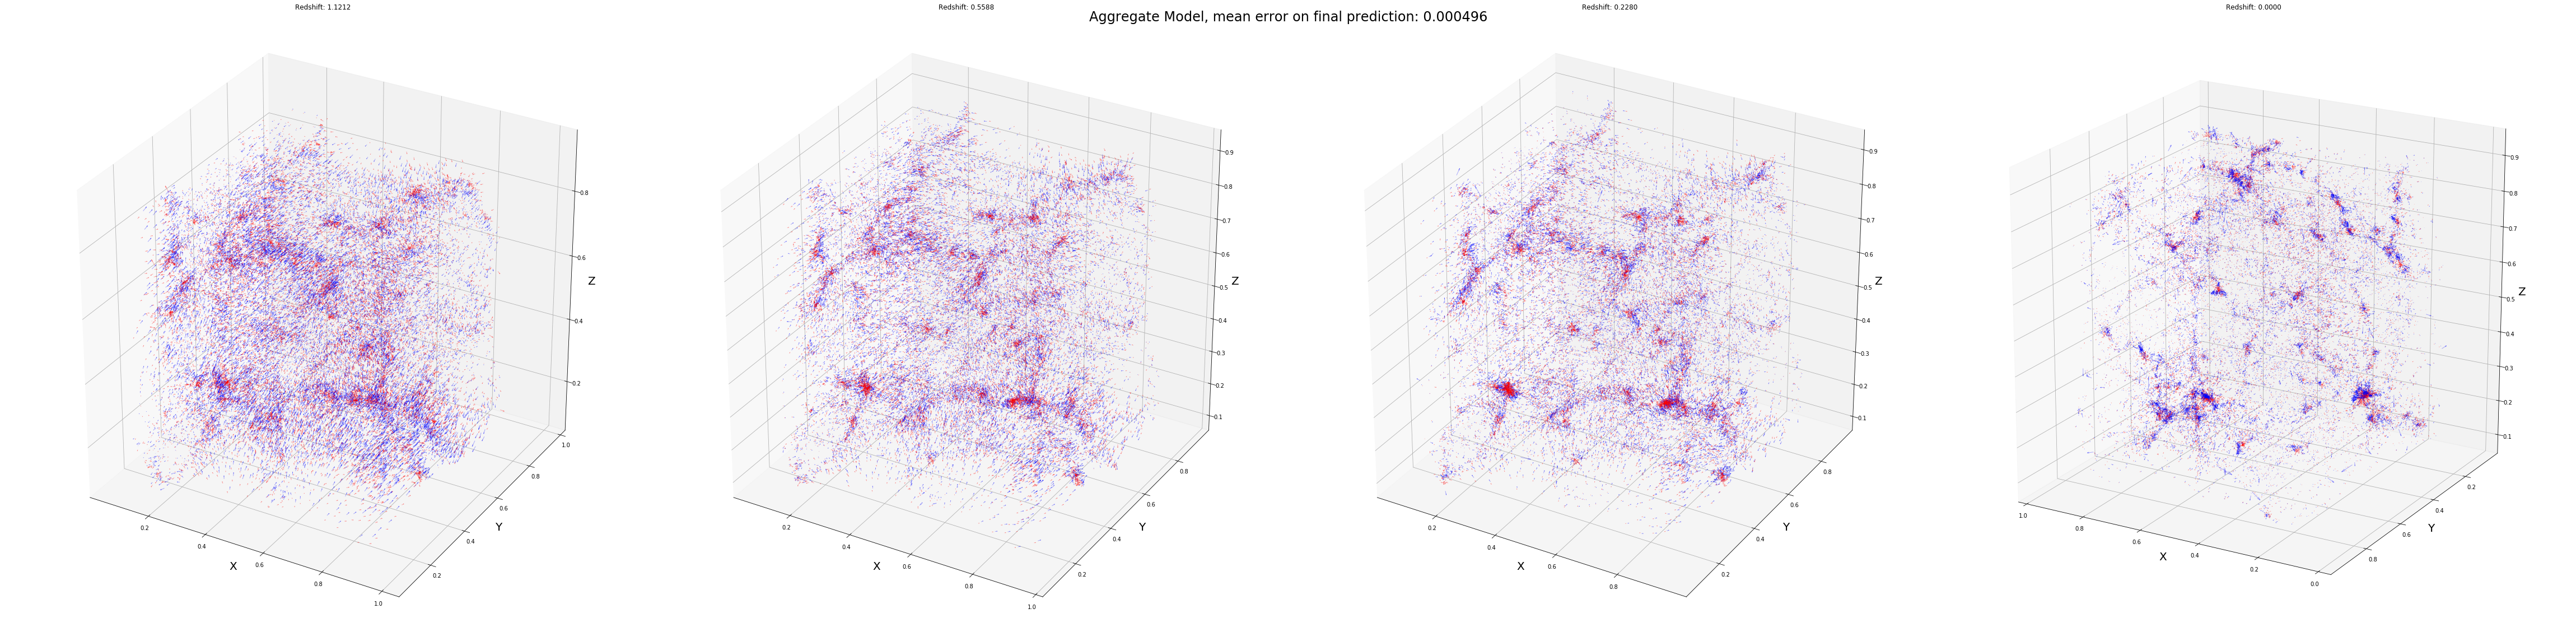

In [5]:
'''
plot point cloud
'''
from IPython import display
#fsize = (16,16)
k = 14
fsize = (k*4,k)
#fsize = (k*4,k*2)
particle_size = (.8,.8)
truth_color = 'red'
pred_color = 'blue'
colors = (truth_color, pred_color)

sample_idx = 185
#rs_idx = 4
#idx_tup = (rs_idx, sample_idx)

plt.close('all')
#fig = plot_3D_pointcloud(xt, xh, *idx_tup, colors=colors, pt_size=particle_size, fsize=fsize)
fig = plt.figure(figsize=fsize)
#subplots_arrow = [245,246,247,248]
subplots_arrow = [141,142,143,144]
subplots_point = [241,242,243,244]
rs_indices = [1,2,3,4]
'''
for subplot, rs_idx in zip(subplots_point, rs_indices):
    print('POINT redshifts[{}] = {}'.format(rs_idx, redshifts[rs_idx]))
    ax_title = 'Redshift: {:.4f}'.format(redshifts[rs_idx])
    ax = fig.add_subplot(subplot, projection='3d')
    ax.title.set_text(ax_title)
    plot_3D_pointcloud_ax(ax, xt, xh, rs_idx, sample_idx, colors=colors, pt_size=particle_size, fsize=fsize)
'''
for subplot, rs_idx in zip(subplots_arrow, rs_indices):
    print('ARROW redshifts[{}] = {}'.format(rs_idx, redshifts[rs_idx]))
    ax_title = 'Redshift: {:.4f}'.format(redshifts[rs_idx])
    ax = fig.add_subplot(subplot, projection='3d')
    ax.title.set_text(ax_title)
    plot_3D_quiver_ax(ax, xt, xh, rs_idx, sample_idx, colors=colors, pt_size=particle_size, fsize=fsize)
fig.suptitle("Aggregate Model, mean error on final prediction: 0.000496", size=24)
plt.tight_layout()
#plt.subplots_adjust(left=0.125, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.2)
plt.gca().view_init(20, 120)
display.display(plt.gcf())
display.clear_output(wait=True)
time.sleep(0.0001)
rotate = False
if rotate:
    for angle in range(0,360, 60):
        #fig.view_init(30, angle)
        plt.gca().view_init(30, angle)
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(0.0001)
#fig.savefig(spath + 'test', dpi=2400,bbox_inches='tight') # warning, this makes a huge image
#fig.savefig(spath + 'test', dpi=1200,bbox_inches='tight') # warning, this makes a huge image

In [8]:
fig.savefig(spath + 'test', dpi=1200,bbox_inches='tight') # warning, this makes a huge image

ValueError: Image size of 76800x19200 pixels is too large. It must be less than 2^16 in each direction.